In [3]:
import cv2
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d
%matplotlib inline

# RGB-D Work

In [4]:
im0 = plt.imread('RGB-data/scene_01/00000-color.png')
im0d = plt.imread('RGB-data/scene_01/00000-depth.png')

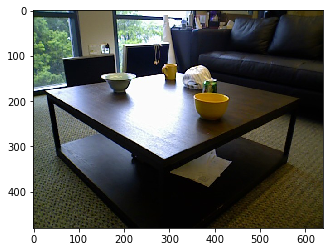

In [5]:
plt.imshow(im0)
plt.show()

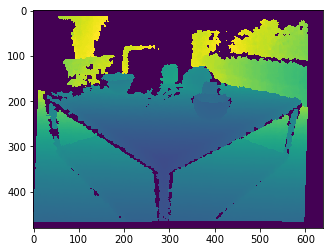

In [6]:
plt.imshow(im0d)
plt.show()

In [7]:
def triangulate(depth_map, fx = 5, fy = 5):
    h,w = depth_map.shape
    xx,yy = np.meshgrid(np.arange(w), np.arange(h))
    mask = (depth_map > 0)
    
    proj_x = (xx[mask] - w/2) * depth_map[mask] / fx
    proj_y = (yy[mask] - h/2) * depth_map[mask] / fy
    
    return np.vstack((proj_x.flatten(), proj_y.flatten(), depth_map[mask].flatten())), mask

In [8]:
pts3, mask = triangulate(im0d, fx = 500, fy=500)
x = pts3[0,:]
y = pts3[1,:]
z = pts3[2,:]

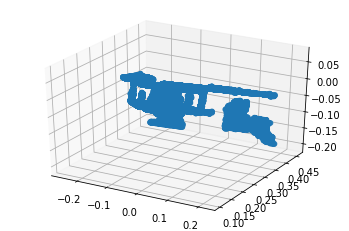

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(x,z,y) # swapped z and y so that the view is nice
plt.show()

In [10]:
h,w = im0d.shape
K = np.array([[500,0,w/2],
              [0,500,h/2],
              [0,0,1]])

In [11]:
def create_output(vertices, colors, filename):
	vertices = np.hstack([vertices,colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [12]:
color_map = im0[mask].reshape(-1,3)
create_output(pts3.T,color_map,'test.ply')

## Feature Matching

In [19]:
im0 = plt.imread('RGB-data/scene_01/00000-color.png')
im0d = plt.imread('RGB-data/scene_01/00000-depth.png')

im1 = plt.imread('RGB-data/scene_01/00050-color.png')
im1d = plt.imread('RGB-data/scene_01/00050-depth.png')

In [20]:
from skimage.measure import ransac
from skimage.transform import AffineTransform

In [21]:
def featureMatching1(im1,im2):
    orb = cv2.ORB_create()
    
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)
    
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
    
    #ransac
    model, inliers = ransac( (src_pts, dst_pts), 
                            AffineTransform, min_samples=4, residual_threshold=4, max_trials=40)
    
    
    
    ## beginning of unnecessary
    n_inliers = np.sum(inliers)
    inlier_kp_left = [ cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers] ]
    inlier_kp_right = [ cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers] ]
    placehold_matches = [cv2.DMatch(idx,idx,1) for idx in range(n_inliers)]
    
    plt.figure(figsize=(15,15))
    final_img = cv2.drawMatches( im1, inlier_kp_left, im2, inlier_kp_right, placehold_matches, None )
    plt.imshow(final_img)
    plt.show()
    ## end of unnecessary
    
    
    return src_pts[inliers], dst_pts[inliers]

def featureMatching(im1,im2):
    orb = cv2.ORB_create()
    
    kp1, des1 = orb.detectAndCompute(im1, None)
    kp2, des2 = orb.detectAndCompute(im2, None)
    
    
    des1 = np.float32(des1)
    des2 = np.float32(des2)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)
    
    #ransac
    model, inliers = ransac( (src_pts, dst_pts), 
                            AffineTransform, min_samples=4, residual_threshold=8, max_trials=40)
    
    
    return src_pts[inliers], dst_pts[inliers]

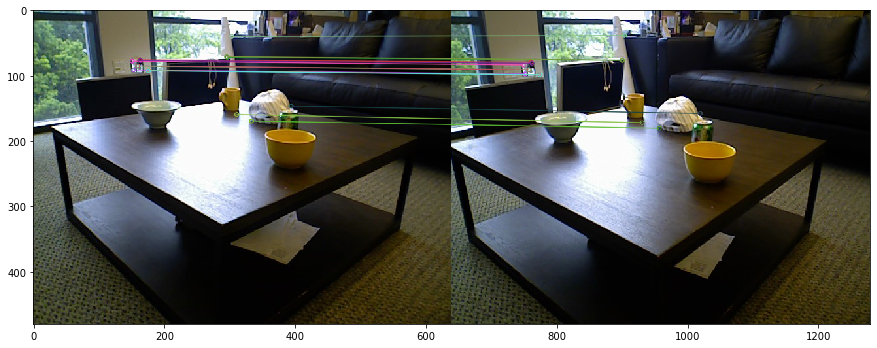

In [22]:
src_pts, dst_pts = featureMatching1( np.uint8(im0*255),np.uint8(im1*255) )

## Eight Point Algorithm

In [23]:
def eight_point(src_pts, dst_pts):
    assert src_pts.shape[0] == 2
    assert dst_pts.shape[0] == 2
    assert src_pts.shape[1] == dst_pts.shape[1]
    assert src_pts.shape[1] >= 8
    
    ones = np.ones(shape=src_pts.shape[1])
    
    #projective coords
    start = np.vstack((src_pts,ones))
    end = np.vstack((dst_pts,ones))
    
    end_x = start[0,:] * end
    end_y = start[1,:] * end
    end_1 = start[2,:] * end
    
    A = np.vstack((end_x,end_y,end_1)).T # create homogenous matrix
    
    ATA = A.T@A
    
    U,S,V = np.linalg.svd(A)
    
    #e = V[:,np.argmin(S)]
    e = V[np.argmin(S),:]
    
    F = e.reshape(3,3)
    
    return F

In [24]:
F = eight_point(src_pts.T, dst_pts.T)

In [25]:
def point8_triangulate(ptsL, ptsR, K, R, t):
    
    qL = ptsL.copy()
    qR = ptsR.copy()
    fx = K[0,0]
    fy = K[1,1]
    cx = K[0,2]
    cy = K[1,2]
    c = np.array([[cx,cy]]).T
    
    qL = qL - c
    qL[0,:] = qL[0,:] / fx
    qL[1,:] = qL[1,:] / fy
    
    qR = qR - c
    qR[0,:] = qR[0,:] / fx
    qR[1,:] = qR[1,:] / fy
    
    qL = np.vstack( (qL,np.ones(qL.shape[1])) )
    qR = np.vstack( (qR,np.ones(qR.shape[1])) )
    
    Rlql = qL
    Rrqr = (R @ qR) * -1
    b = t    
    
    zhatL = np.zeros(shape=(1,ptsL.shape[1]))
    zhatR = np.zeros(shape=(1,ptsR.shape[1]))
    for i in range(ptsL.shape[1]):
        R_lidx = Rlql[:,i].reshape(3,1)
        R_ridx = Rrqr[:,i].reshape(3,1)
        A = np.hstack((R_lidx,R_ridx))
        
        zhat = np.linalg.lstsq(A,b,rcond=None)[0]
        zhatL[:,i] = zhat[0]
        zhatR[:,i] = zhat[1]
    PL = zhatL * qL
    PR = zhatR * qR
    
    P1 = PL
    P2 = R @ PR + t
    pts3 = (P1+P2)/2
    return pts3
def decomposeE(F, src_pts, dst_pts, K):
    E = K.T @ F @ K # fundamental
    
    U,S,VT = np.linalg.svd(E)
    s = (S[0] + S[1])/2
    S = np.array([[s,0,0], [0,s,0], [0,0,0]])
    E = U @ S @ VT
    
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])
    
    U,S,VT = np.linalg.svd(E)
    
    R1 = U @ W @ VT
    R2 = U @ W.T @ VT
    R3 = U @ W @ VT
    R4 = U @ W.T @ VT
    
    C1 = U[:,2].reshape(3,1)
    C2 = -U[:,2].reshape(3,1)
    C3 = U[:,2].reshape(3,1)
    C4 = U[:,2].reshape(3,1)
    
    #check rotation determinants
    if np.linalg.det(R1) < 0:
        R1 = -R1
        C1 = -C1
    if np.linalg.det(R2) < 0:
        R2 = -R2
        C2 = -C2
    if np.linalg.det(R3) < 0:
        R3 = -R3
        C3 = -C3
    if np.linalg.det(R4) < 0:
        R4 = -R4
        C4 = -C4
    pts3_1 = point8_triangulate(src_pts, dst_pts, K, R1.T, -R1.T@C1)
    pts3_2 = point8_triangulate(src_pts, dst_pts, K, R2.T, -R2.T@C2)
    pts3_3 = point8_triangulate(src_pts, dst_pts, K, R3.T, -R3.T@C3)
    pts3_4 = point8_triangulate(src_pts, dst_pts, K, R4.T, -R4.T@C4)
    
    z_1 = R1[2,:]@(pts3_1 - C1)
    z_2 = R2[2,:]@(pts3_2 - C2)
    z_3 = R3[2,:]@(pts3_3 - C3)
    z_4 = R4[2,:]@(pts3_4 - C4)
    
    s1 = (z_1 > 0).sum()
    s2 = (z_2 > 0).sum()
    s3 = (z_3 > 0).sum()
    s4 = (z_4 > 0).sum()
    
    max_sum = max([s1,s2,s3,s4])
    if max_sum == s1:
        return R1.T, -R1.T@C1
    elif max_sum==s2:
        return R2.T, -R2.T@C2
    elif max_sum==s3:
        return R3.T, -R3.T@C3
    else:
        return R4.T, -R4.T@C4

In [26]:
R,t = decomposeE(F, src_pts.T, dst_pts.T, K)

In [27]:
def visual(R,t,ax):
    x = np.array([[1,0,0,1]]).T
    y = np.array([[0,1,0,1]]).T
    z = np.array([[0,0,1,1]]).T
    ze = np.array([[0,0,0,1]]).T
    
    transform = np.hstack((R,t))
    
    xt = transform @ x
    yt = transform @ y
    zt = transform @ z
    zet = transform @ ze
    
    vecA = xt - zet
    vecB = yt - zet
    vecC = zt - zet
    assert (vecA.T @ vecB)[0] <1e-5, f'nonzero dot {(vecA.T @ vecB)[0]}'
    assert (vecA.T @ vecC)[0] <1e-5, f'nonzero dot {(vecA.T @ vecC)[0]}'
    assert (vecB.T @ vecC)[0] <1e-5, f'nonzero dot {(vecB.T @ vecC)[0]}'
    
    pts = np.hstack((xt,yt,zt,zet))
    ax.scatter(pts[0,:], pts[1,:], pts[2,:])
    xvec = np.hstack((zet,xt))
    yvec = np.hstack((zet,yt))
    zvec = np.hstack((zet,zt))
    ax.plot(xvec[0,:], xvec[1,:], xvec[2,:],c='blue')
    ax.plot(yvec[0,:], yvec[1,:], yvec[2,:],c='red')
    ax.plot(zvec[0,:], zvec[1,:], zvec[2,:],c='green')

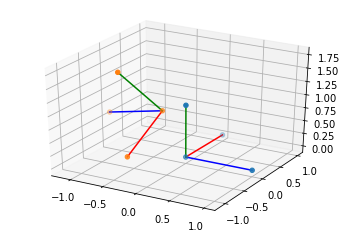

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

visual(np.eye(3), np.array([[0,0,0]]).T, ax)
visual(R,t,ax)

plt.show()

## PnP

In [29]:
def triangulate(depth_map, fx = 5, fy = 5):
    h,w = depth_map.shape
    xx,yy = np.meshgrid(np.arange(w), np.arange(h))
    mask = (depth_map > 0)
    
    proj_x = (xx[mask] - w/2) * depth_map[mask] / fx
    proj_y = (yy[mask] - h/2) * depth_map[mask] / fy
    
    return np.vstack((proj_x.flatten(), proj_y.flatten(), depth_map[mask].flatten())), mask

In [31]:
pts3, mask = triangulate(im0d, fx=500, fy=500)
src_ptsfl, dst_ptsfl = featureMatching( np.uint8(im0*255),np.uint8(im1*255) )


src_pts = src_ptsfl.astype(np.uint8)
dst_pts = dst_ptsfl.astype(np.uint8)

pt_mask = np.zeros(im0d.shape,dtype=bool)
pt_mask[ src_pts[:,1], src_pts[:,0] ] = True # mark all src coords at True
pt_mask = pt_mask & mask

src_mask = pt_mask[ src_pts[:,1], src_pts[:,0] ]
src_ft = src_pts[src_mask,:]

dst_ft = dst_pts[src_mask,:]
dst_ft = dst_ft.astype(np.float32)

depth_ft = im0d[ src_pts[:,1], src_pts[:,0] ]
depth_ft = depth_ft[src_mask]

In [32]:
def featureTriangulate(pts2, depth_pts, K):
    fx = K[0,0]
    fy = K[1,1]
    favg = (fx+fy)/2

    cx = K[0,2]
    cy = K[1,2]
    c = np.array([[cx,cy]]).T
    
    pts_t = (pts2.T-c)*depth_pts/favg
    pts3 = np.vstack((pts_t,depth_pts))
    return pts3

In [33]:
pts3_ft = featureTriangulate(src_ft, depth_ft, K)

In [34]:
#ret,rvec,tvec,_ = cv2.solvePnPRansac(pts3D_feature.T, dst_ft, K1, D1, useExtrinsicGuess=True, rvec=extr_R,flags=cv2.SOLVEPNP_SQPNP) # cv2.SOLVEPNP_SQPNP

In [35]:
ret,rvec,tvec = cv2.solvePnP(pts3_ft.T, dst_ft, K, np.array([0,0,0,0]),\
                             flags=cv2.SOLVEPNP_SQPNP) # cv2.SOLVEPNP_SQPNP

In [36]:
rot,_ = cv2.Rodrigues(rvec)

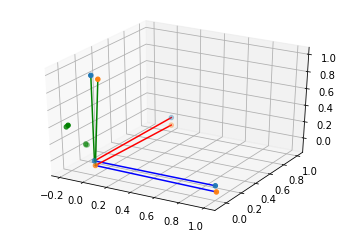

In [37]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

visual(np.eye(3), np.array([[0,0,0]]).T, ax)
visual(rot,tvec,ax)
ax.scatter(pts3_ft[0,:], pts3_ft[1,:], pts3_ft[2,:],c='green')
plt.show()

In [271]:
def motion8(im0, im1, K):
    src_pts, dst_pts = featureMatching( np.uint8(im0*255),np.uint8(im1*255) )
    F = eight_point(src_pts.T, dst_pts.T)
    R,t = decomposeE(F, src_pts.T, dst_pts.T, K)
    return R,t

In [287]:
def motionPnP(im0, im0d, im1, K):
    fx = K[0,0]
    fy = K[1,1]
    
    pts3, mask = triangulate(im0d, fx=fx, fy=fy)
    src_ptsfl, dst_ptsfl = featureMatching( np.uint8(im0*255),np.uint8(im1*255) )
    
    src_pts = src_ptsfl.astype(np.uint8)
    dst_pts = dst_ptsfl.astype(np.uint8)

    pt_mask = np.zeros(im0d.shape,dtype=bool)
    pt_mask[ src_pts[:,1], src_pts[:,0] ] = True # mark all src coords at True
    pt_mask = pt_mask & mask

    src_mask = pt_mask[ src_pts[:,1], src_pts[:,0] ]
    src_ft = src_pts[src_mask,:]

    dst_ft = dst_pts[src_mask,:]
    dst_ft = dst_ft.astype(np.float32)

    depth_ft = im0d[ src_pts[:,1], src_pts[:,0] ]
    depth_ft = depth_ft[src_mask]
    
    pts3_ft = featureTriangulate(src_ft, depth_ft, K)
    ret,rvec,tvec = cv2.solvePnP(pts3_ft.T, dst_ft, K, np.array([0,0,0,0]),\
                             flags=cv2.SOLVEPNP_SQPNP) # cv2.SOLVEPNP_SQPNP
    rot,_ = cv2.Rodrigues(rvec)
    
    return rot, tvec

In [315]:
def motionPnP8(im0,im0d, im1, K):
    fx = K[0,0]
    fy = K[1,1]
    
    pts3, mask = triangulate(im0d, fx=fx, fy=fy)
    src_ptsfl, dst_ptsfl = featureMatching( np.uint8(im0*255),np.uint8(im1*255) )
    
    src_pts = src_ptsfl.astype(np.uint8)
    dst_pts = dst_ptsfl.astype(np.uint8)

    pt_mask = np.zeros(im0d.shape,dtype=bool)
    pt_mask[ src_pts[:,1], src_pts[:,0] ] = True # mark all src coords at True
    pt_mask = pt_mask & mask

    src_mask = pt_mask[ src_pts[:,1], src_pts[:,0] ]
    src_ft = src_pts[src_mask,:]

    dst_ft = dst_pts[src_mask,:]
    dst_ft = dst_ft.astype(np.float32)

    depth_ft = im0d[ src_pts[:,1], src_pts[:,0] ]
    depth_ft = depth_ft[src_mask]
    
    pts3_ft = featureTriangulate(src_ft, depth_ft, K)
    
    #8 point
    F = eight_point(src_pts.T, dst_pts.T)
    R,t = decomposeE(F, src_pts.T, dst_pts.T, K)
    
    
    ret,rvec,tvec,_ = cv2.solvePnPRansac(pts3_ft.T, dst_ft, K, np.array([0,0,0,0]) \
                                         , useExtrinsicGuess=True, rvec=R.T,\
                                         flags=cv2.SOLVEPNP_SQPNP) # cv2.SOLVEPNP_SQPNP
    
    rot,_ = cv2.Rodrigues(rvec)
    return rot, tvec    

In [316]:
def reformat(n):
    return '0'* (5-len(str(n))) + str(n)
def getSet(n):
    im0d = plt.imread(f'RGB-data/scene_01/00000-depth.png')
    
    h,w = im0d.shape
    setIm = np.zeros( (n,h,w,3) ,dtype=np.uint8)
    setDepth = np.zeros( (n,h,w) ,dtype=np.float32)
    for i in range(n):
        str_i = reformat(i)
        im0 = np.uint8( plt.imread(f'RGB-data/scene_01/{str_i}-color.png')*255 )
        im0d = plt.imread(f'RGB-data/scene_01/{str_i}-depth.png')
        
        setIm[i] = im0
        setDepth[i] = im0d
        
    return setIm, setDepth

In [317]:
def videoMotion(setIm, setDepth, n, K):
    
    R = np.eye(3)
    t = np.array([[0,0,0]]).T
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    visual(R,t,ax)
    for i in range(1,n):
        rot,tvec = motionPnP8(setIm[i-1], setDepth[i-1], setIm[i], K)
        R = rot @ R
        t = tvec + t
        visual(R,t,ax)
    plt.show()

[  4.12566814  -9.73460452 -17.20192502  -5.00996445   2.8783787
   7.54085899  -5.94954012 -20.78523626 -14.26351562 -10.96005131
   3.24280534  -0.02356175  -4.14744531   5.25284153   5.85386
  -2.11931588  -3.6128806   -2.51050845   5.44166327  -6.97433244
  -7.55489095  -6.66704002   2.45783694  -6.03602925   1.22563472
   6.19770079   6.15179606  -5.96870675  11.4884727   -1.29918465
  -7.42651853  -3.86274907  -0.58163142   5.07395512   4.07199444
  -4.67668589   4.28053941   6.19709476  -1.41195727   6.41574584
  -5.21412745   3.65232199   2.38106729   3.04141649  -5.60344362
 -21.49306252   3.14451022  -3.56221491 -20.83252592  -5.47822496
   7.69077994  -6.98650818   3.23704926  -8.16963326   6.15179606
   5.41585263   3.09725692   6.04892524  11.88281593   3.17534174
  -4.47108934  -2.16985924   2.94427854   2.23395677 -11.54762496
  -4.74529537  -5.48584999   4.33919604  -2.64404633  -3.09752524
  13.73020526   2.3357049   -6.10325154  -9.67384651   6.61275983
  -4.35796606 

error: OpenCV(4.5.5) /io/opencv/modules/calib3d/src/calibration.cpp:652: error: (-5:Bad argument) Distortion coefficients must be 1x4, 4x1, 1x5, 5x1, 1x8, 8x1, 1x12, 12x1, 1x14 or 14x1 floating-point vector in function 'cvProjectPoints2Internal'


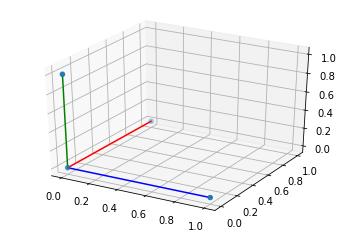

In [318]:
n = 20
setIm, setDepth = getSet(n)
videoMotion(setIm,setDepth,n, K)